In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import zipfile

z = zipfile.ZipFile('archive.zip')
z.extractall()

In [6]:
folder = './brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder +  filename
    destination = folder + "Y_" + str(count)+".jpg"
    os.rename(source,destination)
    count += 1

print("All images are renamed in the yes directory")

All images are renamed in the yes directory


In [8]:
folder = './brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder +  filename
    destination = folder + "N_" + str(count)+".jpg"
    os.rename(source,destination)
    count += 1

print("All images are renamed in the no directory")

All images are renamed in the no directory


## Exploratory Data Analysis

In [9]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

310
196


### Plot

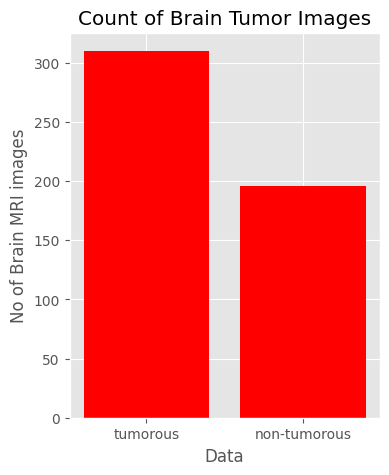

In [10]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(4,5))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain MRI images")
plt.title("Count of Brain Tumor Images")
plt.show()

## Data Augmentation

In [ ]:
# 155(yes)
# 98(no) - Dataset is imbalanced
# We can generate extra images using image data generator from Keras

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [12]:
def timing(sec_elapsed):
    h = int(sec_elapsed/ (60*60))
    m = int(sec_elapsed % (60*60)/60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [13]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
             i += 1
             if i > n_generated_samples:
                 break
         

In [22]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes' 
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir=yes_path,
              n_generated_samples=6,
              save_to_dir=augmented_data_path+'yes')

augmented_data(file_dir=no_path,
              n_generated_samples=9,
              save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:4:30.022275924682617


In [24]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = n_pos + n_neg
    pos_percentage = (n_pos*100)/n
    neg_percentage = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"Number of Positive sample: {pos_percentage} %")
    print(f"Number of Negative sample: {neg_percentage} %")

In [25]:
data_summary(augmented_data_path)

Number of sample: 4129
Number of Positive sample: 52.53087914749334 %
Number of Negative sample: 47.46912085250666 %


In [26]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

2169
1960


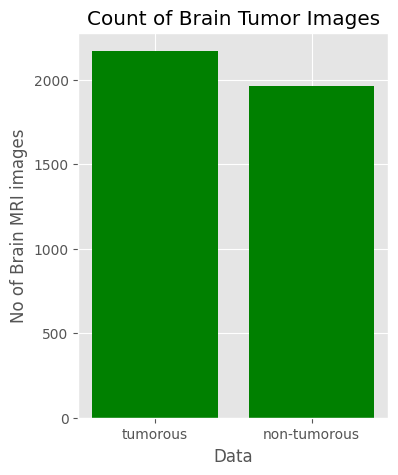

In [27]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(4,5))

plt.bar(typex, values, color="green")

plt.xlabel("Data")
plt.ylabel("No of Brain MRI images")
plt.title("Count of Brain Tumor Images")
plt.show()

## Data Preprocessing

### Using OpenCV and Detect contour and remove useless areas

- Convert BGR to BRAY
- GaussianBlur
- Threshold
- Erode
- Dialate
- Find Contours


In [ ]:
!pip install imutils

In [28]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    cv2.erode(thres, None, iterations = 2)
    cv2.dilate(thres, None, iterations = 2)
    contours = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                       top=False, bottom=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original image')

        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                       top=False, bottom=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title("Cropped Image")
        plt.show()

    return new_image

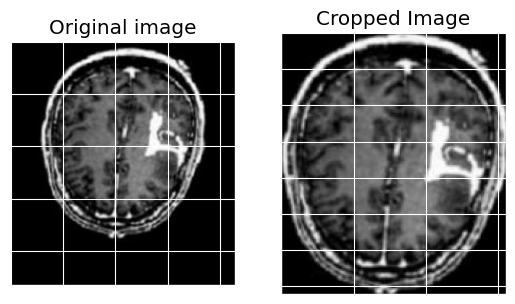

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [30]:
img = cv2.imread('augmented_data/yes/aug_Y_99_0_6759.jpg')
crop_brain_tumor(img, True)

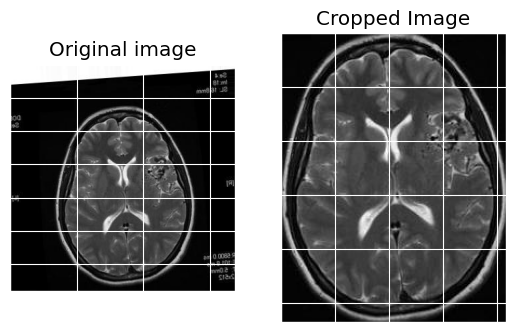

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [4, 4, 4],
        [3, 3, 3],
        [2, 2, 2]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [4, 4, 4],
        [3, 3, 3]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [4, 4, 4],
        [3, 3, 3]],

       ...,

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]], dtype=uint8)

In [31]:
img = cv2.imread('augmented_data/no/aug_N_99_0_275.jpg')
crop_brain_tumor(img, True)

In [98]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    if filename == '.ipynb_checkpoints':
        continue
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)

for filename in os.listdir(folder2):
    if filename == '.ipynb_checkpoints':
        continue
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

## Image Loading

In [43]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X = []
    y = []

    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            if filename == '.ipynb_checkpoints' :
                continue
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
                
    X = np.array(X)
    y = np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X Shape is : {X.shape}")
    print(f"y Shape is : {y.shape}")
    return X,y


In [44]:
augmented_path = 'augmented_data/'
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 4128
X Shape is : (4128, 240, 240, 3)
y Shape is : (4128,)


In [47]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        images = X[np.argwhere(y ==  label)]
        n_images = images[:n]

    columns_n = 10
    rows_n = int(n/columns_n)

    plt.figure(figsize=(20,10))

    i = 1
    for image in n_images:
        plt.subplot(rows_n, columns_n, i)
        plt.imshow(image[0])

        plt.tick_params(axis='both', which='both',
                       top=False,bottom=False, left=False, right=False,
                       labelbottom=False, labeltop=False)
        i += 1

    label_to_str = lambda label: "Yes" if label == 1 else "No"
    plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
    plt.show()
    

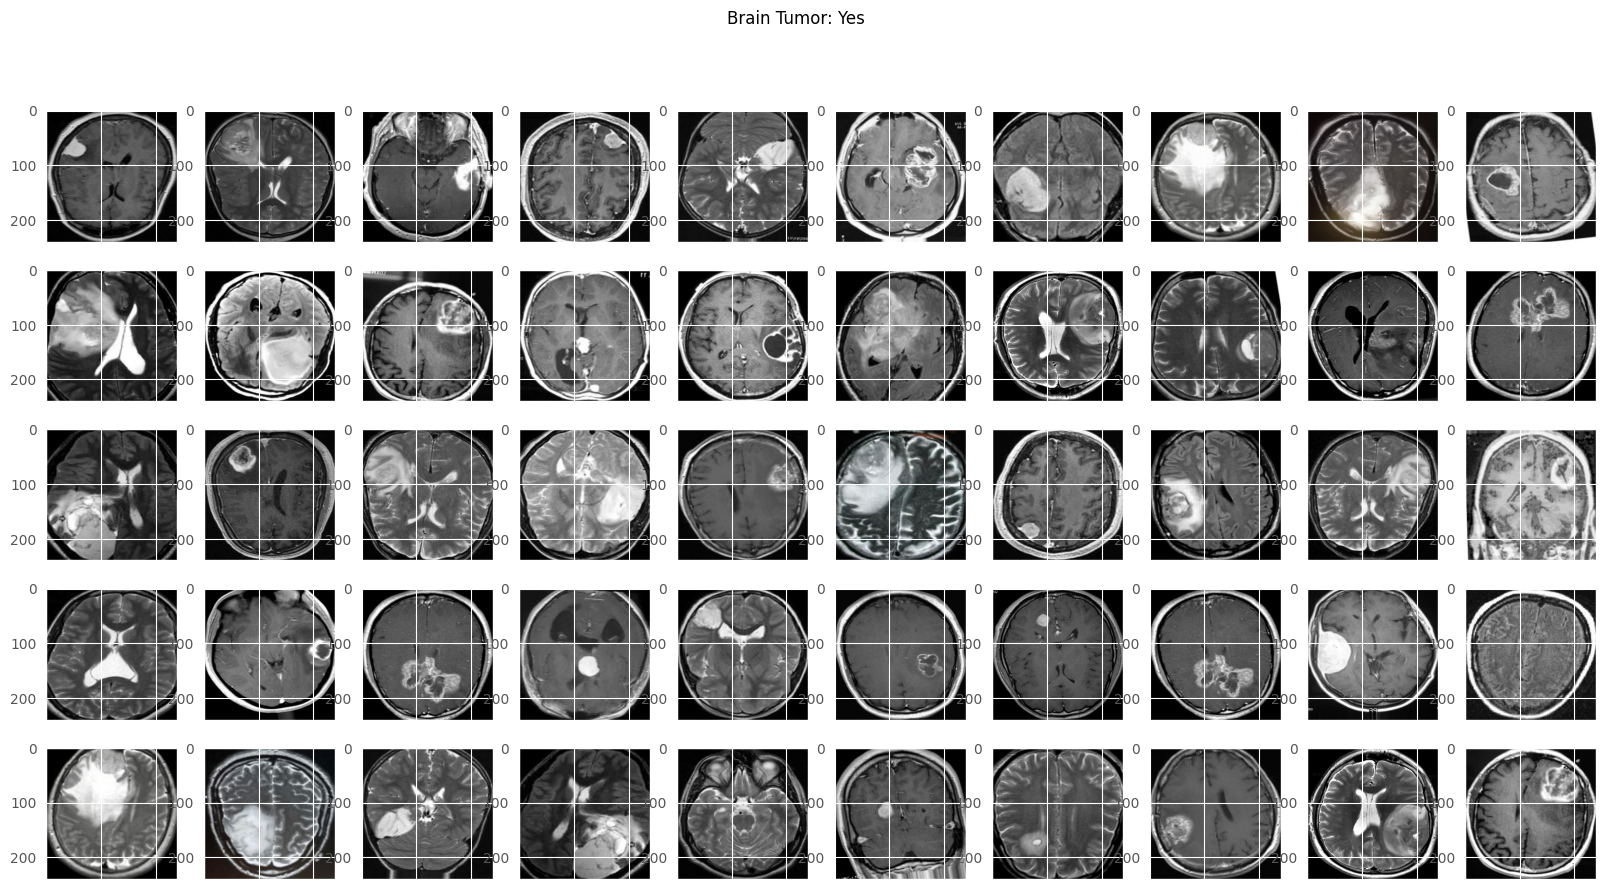

In [48]:
plot_sample_images(X,y)

## Data Splitting

### Train , Test , Validation

In [99]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [100]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)

if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)

if not os.path.isdir('tumorous_and_nontumorous/validation'):
    val_dir = os.path.join(base_dir , 'validation')
    os.mkdir(val_dir)

In [101]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)

if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)

if not os.path.isdir('tumorous_and_nontumorous/validation/tumorous'):
    infected_val_dir = os.path.join(val_dir, 'tumorous')
    os.mkdir(infected_val_dir)

In [102]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)

if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)

if not os.path.isdir('tumorous_and_nontumorous/validation/nontumorous'):
    healthy_val_dir = os.path.join(val_dir, 'nontumorous')
    os.mkdir(healthy_val_dir)

In [103]:
original_dataset_tumorous = os.path.join('augmented_data','yes/')
original_dataset_nontumorous = os.path.join('augmented_data','no/')

### For infected tumerous training data

In [104]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,1627):
    if files[i] == '.ipynb_checkpoints':
        continue
    fnames.append(files[i])

for fname in fnames:
    if fname == '.ipynb_checkpoints':
        continue
    src = os.path.join(original_dataset_tumorous, fname)
    dest = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dest)

### For infected tumerous testing data

In [105]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(1627,2045):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dest = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dest)

### For infected tumerous validation data

In [106]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(2055,2169):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dest = os.path.join(infected_val_dir, fname)
    shutil.copyfile(src, dest)

### For healthy non-tumerous training data

In [107]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,1470):
    if files[i] == '.ipynb_checkpoints':
        continue
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dest = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dest)

### For healthy non-tumerous testing data

In [108]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(1470,1862):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dest = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dest)

### For healthy non-tumerous validation data

In [109]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(1862,1960):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dest = os.path.join(healthy_val_dir, fname)
    shutil.copyfile(src, dest)

## Model Building

In [82]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip = 0.4,
                  vertical_flip = 0.4,
                  rotation_range = 40,
                  shear_range = 0.2,
                  width_shift_range = 0.4,
                  height_shift_range = 0.4,
                  fill_mode = 'nearest')

test_data_gen = ImageDataGenerator(rescale = 1.0/255 )
valid_data_gen = ImageDataGenerator(rescale = 1.0/255 )

In [83]:
train_generator = train_data_gen.flow_from_directory('tumorous_and_nontumorous/train/',batch_size = 32, target_size = (240,240), class_mode = 'categorical' , shuffle = True,
                                  seed = 42, color_mode = 'rgb')

Found 3095 images belonging to 2 classes.


In [86]:
test_generator = test_data_gen.flow_from_directory('tumorous_and_nontumorous/test/',batch_size = 32, target_size = (240,240), class_mode = 'categorical' , shuffle = True,
                                  seed = 42, color_mode = 'rgb')

Found 810 images belonging to 2 classes.


In [87]:
valid_generator = valid_data_gen.flow_from_directory('tumorous_and_nontumorous/validation/',batch_size = 32, target_size = (240,240), class_mode = 'categorical' , shuffle = True,
                                  seed = 42, color_mode = 'rgb')

Found 212 images belonging to 2 classes.


In [88]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [89]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [110]:
base_model = VGG19(input_shape = (240,240,3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

### Creating Callbacks

In [111]:
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min', patience = 4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch')
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [112]:
sgd = SGD(learning_rate = 0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

D:\New folder\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [115]:
history_01 = model_01.fit(train_generator, steps_per_epoch = 10, epochs = 20, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4889 - loss: 0.7483
Epoch 1: val_loss did not improve from 0.78506
10/10 ━━━━━━━━━━━━━━━━━━━━ 109s 11s/step - accuracy: 0.4914 - loss: 0.7465 - val_accuracy: 0.5377 - val_loss: 0.8367 - learning_rate: 1.0000e-04
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5410 - loss: 0.7371
Epoch 2: val_loss improved from 0.78506 to 0.72509, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 11s/step - accuracy: 0.5436 - loss: 0.7343 - val_accuracy: 0.4057 - val_loss: 0.7251 - learning_rate: 1.0000e-04
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5275 - loss: 0.7302
Epoch 3: val_loss did not improve from 0.72509
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 10s/step - accuracy: 0.5282 - loss: 0.7293 - val_accuracy: 0.5189 - val_loss: 0.7358 - learning_rate: 1.0000e-04
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5613 - loss: 0.6948
Epoch 4: val_loss improved from 0.72509 to 0.70110, saving 

D:\New folder\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 10: val_loss improved from 0.69275 to 0.66664, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 9s/step - accuracy: 0.6573 - loss: 0.6255 - val_accuracy: 0.5943 - val_loss: 0.6666 - learning_rate: 1.0000e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6662 - loss: 0.6266
Epoch 11: val_loss did not improve from 0.66664
10/10 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step - accuracy: 0.6659 - loss: 0.6267 - val_accuracy: 0.5849 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5824 - loss: 0.6572
Epoch 12: val_loss did not improve from 0.66664
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 10s/step - accuracy: 0.5837 - loss: 0.6566 - val_accuracy: 0.5943 - val_loss: 0.7078 - learning_rate: 1.0000e-04
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5973 - loss: 0.6544
Epoch 13: val_loss did not improve from 0.66664
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 10s/step - accuracy: 0.5962 - loss: 0.6554 - val_accuracy

## Plot Performance

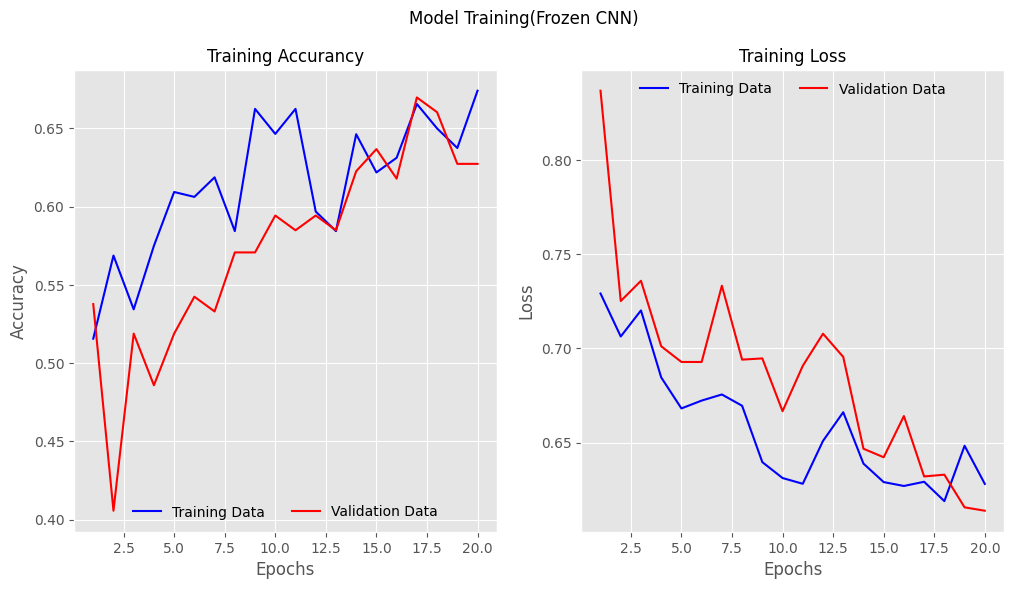

In [120]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training(Frozen CNN)", fontsize = 12)
max_epoch = len(history_01.history['accuracy']) + 1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accurancy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format="jpeg", dpi=100, bbox_inches = 'tight')

In [127]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath = "model_weights/vgg19_model_01.weights.h5", overwrite=True)

## Loading and Checking Model

In [128]:
model_01.load_weights('model_weights/vgg19_model_01.weights.h5')
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.6852 - loss: 0.5877


D:\New folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.7063 - loss: 0.5700


In [129]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Accuracy: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Accuracy: {vgg_test_eval_01[1]}')


Validation Loss: 0.6138181686401367
Validation Accuracy: 0.6273584961891174
Testing Loss: 0.5588616728782654
Testing Accuracy: 0.7209876775741577


In [131]:
filenames = test_generator.filenames
nb_samples = len(filenames)

vgg_predictions_01 = model_01.predict(test_generator, steps=nb_samples, verbose=1)
y_pred = np.argmax(vgg_predictions_01, axis=1)

810/810 ━━━━━━━━━━━━━━━━━━━━ 159s 188ms/step


D:\New folder\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## Incremental Unfreezing and Finetuning

In [133]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_5',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [134]:
# Removing block5_conv3 and block5_conv4

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model_02.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [135]:
sgd = SGD(learning_rate = 0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

D:\New folder\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [136]:
history_02 = model_02.fit(train_generator, steps_per_epoch = 10, epochs = 10, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6637 - loss: 0.6053
Epoch 1: val_loss did not improve from 0.61382
10/10 ━━━━━━━━━━━━━━━━━━━━ 115s 11s/step - accuracy: 0.6628 - loss: 0.6069 - val_accuracy: 0.6792 - val_loss: 0.6152 - learning_rate: 1.0000e-04
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6233 - loss: 0.6467
Epoch 2: val_loss did not improve from 0.61382
10/10 ━━━━━━━━━━━━━━━━━━━━ 104s 11s/step - accuracy: 0.6249 - loss: 0.6453 - val_accuracy: 0.6840 - val_loss: 0.6141 - learning_rate: 1.0000e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6669 - loss: 0.6059
Epoch 3: val_loss did not improve from 0.61382
10/10 ━━━━━━━━━━━━━━━━━━━━ 107s 11s/step - accuracy: 0.6696 - loss: 0.6035 - val_accuracy: 0.6415 - val_loss: 0.6318 - learning_rate: 1.0000e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6765 - loss: 0.6223
Epoch 4: val_loss improved from 0.61382 to 0.60535, saving model to model.keras
10/10 ━━━━━━

D:\New folder\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 10: val_loss improved from 0.58537 to 0.58178, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 89s 9s/step - accuracy: 0.6976 - loss: 0.5723 - val_accuracy: 0.7075 - val_loss: 0.5818 - learning_rate: 1.0000e-04


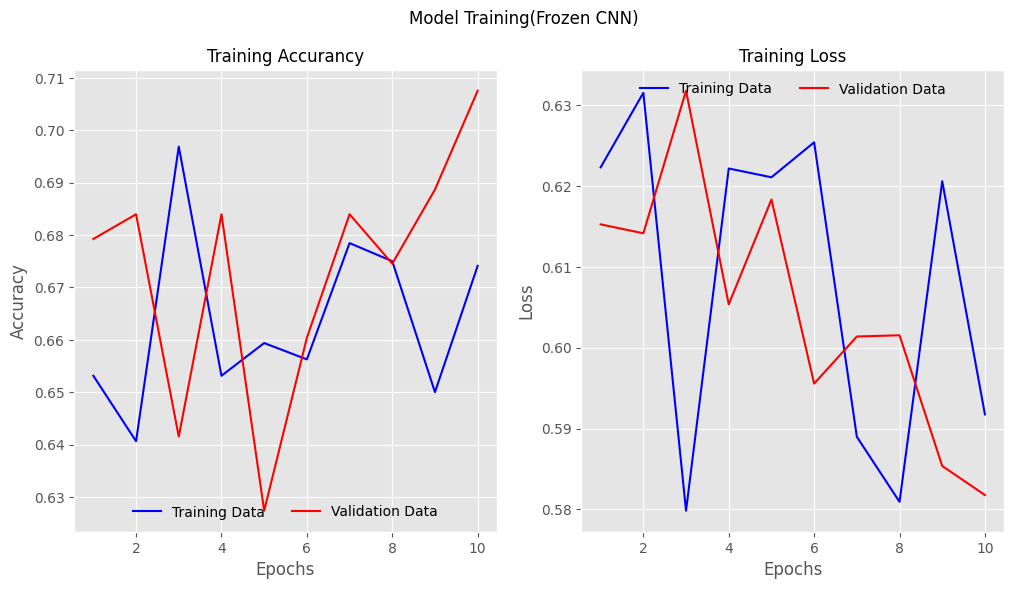

In [137]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training(Frozen CNN)", fontsize = 12)
max_epoch = len(history_02.history['accuracy']) + 1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accurancy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format="jpeg", dpi=100, bbox_inches = 'tight')

In [138]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath = "model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [140]:
model_02.load_weights('model_weights/vgg19_model_02.weights.h5')
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.6975 - loss: 0.5958
26/26 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - accuracy: 0.7539 - loss: 0.5058


In [141]:
print(f'Validation Loss: {vgg_val_eval_02[0]}')
print(f'Validation Accuracy: {vgg_val_eval_02[1]}')
print(f'Testing Loss: {vgg_test_eval_02[0]}')
print(f'Testing Accuracy: {vgg_test_eval_02[1]}')


Validation Loss: 0.5817809104919434
Validation Accuracy: 0.7075471878051758
Testing Loss: 0.5103303790092468
Testing Accuracy: 0.7456790208816528


### Unfreezing the Entire Network

In [142]:
x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate = 0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])
model_03.summary()

D:\New folder\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [143]:
history_03 = model_03.fit(train_generator, steps_per_epoch = 10, epochs = 5, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7126 - loss: 0.5661
Epoch 1: val_loss did not improve from 0.58178
10/10 ━━━━━━━━━━━━━━━━━━━━ 115s 11s/step - accuracy: 0.7132 - loss: 0.5655 - val_accuracy: 0.6698 - val_loss: 0.5946 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6625 - loss: 0.6027
Epoch 2: val_loss did not improve from 0.58178
10/10 ━━━━━━━━━━━━━━━━━━━━ 106s 11s/step - accuracy: 0.6656 - loss: 0.6005 - val_accuracy: 0.6274 - val_loss: 0.5847 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6477 - loss: 0.6031
Epoch 3: val_loss did not improve from 0.58178
10/10 ━━━━━━━━━━━━━━━━━━━━ 106s 11s/step - accuracy: 0.6485 - loss: 0.6024 - val_accuracy: 0.6557 - val_loss: 0.5932 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6356 - loss: 0.6456
Epoch 4: val_loss improved from 0.58178 to 0.55938, saving model to model.keras
10/10 ━━━━━━━━━━

In [145]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath = "model_weights/vgg_unfrozen.weights.h5", overwrite=True)

In [146]:
model_03.load_weights('model_weights/vgg_unfrozen.weights.h5')
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.7079 - loss: 0.5782
26/26 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.7678 - loss: 0.4897


In [147]:
print(f'Validation Loss: {vgg_val_eval_03[0]}')
print(f'Validation Accuracy: {vgg_val_eval_03[1]}')
print(f'Testing Loss: {vgg_test_eval_03[0]}')
print(f'Testing Accuracy: {vgg_test_eval_03[1]}')

Validation Loss: 0.5651587843894958
Validation Accuracy: 0.7216981053352356
Testing Loss: 0.4938998520374298
Testing Accuracy: 0.7641975283622742
